## 预处理与分析

读取数据并处理后划分训练测试集
* train：14位说话人的数据
* test：其余2位说话人的数据

使用librosa包进行mfcc特征提取
* librosa.feature.mfcc()返回的结果是一个(n_mfcc, n_frame)的array
* 模板的帧数与待测样本的帧数不一定相同，不过选取的特征维度需要相同，为了计算它们之间的欧氏距离
* 这里都使用39维度的mfcc特征提取

In [22]:
import os
import librosa
data = []
for number in range(10):
    tmp = []
    mydir = 'C:/Users/Rhodia/Desktop/records/records/digit_' + str(number) + '/'
    myfile = os.listdir(mydir)
    for i in range(len(myfile)):
        url = mydir + myfile[i]
        y, sr = librosa.load(url,sr=16000)
        mfccs = librosa.feature.mfcc(y=y,sr=sr,n_mfcc=39)
        tmp.append(mfccs)
    data.append(tmp)

train = []
test = []
for i in range(len(data)):
    train.append(data[i][0:14])
    test.append(data[i][14:])

final_train = []
final_test = []

no = 0
for num in train:
    for template in num:
        final_train.append([template,no])
    no += 1
        
no = 0
for num in test:
    for template in num:
        final_test.append([template,no])
    no += 1

# print([len(final_train),len(final_test)])
# [140, 20]

训练集为每个英文数字的多个模板，将输入（测试集）与每一个模板都进行匹配，选择最佳匹配模板，它对应的数字就是该输入预测的结果

## DTW算法实现

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def dist(a, b):
    # calculate the Euclidean Distance between two frames
    return np.sqrt(np.sum((a-b)**2))

def genDistMat(mfcc1, mfcc2):
    # generate a size (m, n) distance matrix
    # m is the number of the input's frames
    # n is the number of the template's frames
    
    x = mfcc1.T
    y = mfcc2.T
    m = np.shape(x)[0]
    n = np.shape(y)[0]
    
    d = []
    for i in range(m): #42
        for j in range(n): #30
            d.append(dist(x[i],y[j]))

    d = np.mat(d).reshape(m,n)
    return d
    
def genAccumulatedMat1(d):
    # generate the accumulated distance matrix
    
    m = np.shape(d)[0]
    n = np.shape(d)[1]
    
    D = np.zeros((m,n))
    
    # calculate the accumulated distance of the first row
    D[0,0] = 2*d[0,0]
    for i in range(1,m):
        D[i,0] = d[i,0] + D[i-1,0]
    for j in range(1,n):
        D[0,j] = np.inf
        
    # calculate the rest rows' accumulated distance
    for i in range(1,m):
        for j in range(1,n):
            current_d = d[i,j]
            D3 = D[i-1,j] + current_d
            D1 = D[i-1,j-1] + 2*current_d
            D2 = np.inf
            if i > 1:
                D2 = D[i-2,j-1] + 3*current_d
            D[i,j] = min([D1,D2,D3])
    return D

def getMinDist1(D):
    # get the edit distance
    
    min_dist = D[-1,-1]/(np.shape(D)[0]+np.shape(D)[1]) # have to be normalized not sure how
    return min_dist

def getPath1(D):
    # get the path from the right bottom of the accumulated matrix
    
    m, n = D.shape
    path = [(m - 1, n - 1)]
    while path[-1] != (0, 0):
        i, j = path[-1]
        if i == 0:
            path.append((0, j - 1))
        elif j == 0:
            path.append((i - 1, 0))
        else:
            arr = np.array([D[i - 1][j - 1],
                            D[i - 2][j - 1],
                            D[i - 1][j    ]])
            argmin = np.argmin(arr)
            if argmin == 0:
                path.append((i - 1, j - 1))
            elif argmin == 1:
                path.append((i - 2, j - 1))
            else:
                path.append((i - 1, j    ))
    return path[::-1]

def plotPath1(path):
    # plot the path
    
    fig, ax = plt.subplots(figsize=(6, 6))
    index1 = [x[0] for x in path]
    index2 = [x[1] for x in path]
    ax.plot(index1, index2)
    xlab = "template"
    ylab = "input"
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.grid(True)

    plt.show()
    
def genAccumulatedMat2(d):
    # generate the accumulated distance matrix
    
    m = np.shape(d)[0]
    n = np.shape(d)[1]
    
    D = np.zeros((m,n))
    
    # calculate the accumulated distance of the first row
    D[0,0] = 2*d[0,0]
    for j in range(1,n):
        D[0,j] = d[0,j] + D[0,j-1]
        
    # calculate the rest rows' accumulated distance
    for i in range(1,m):
        for j in range(0,n):
            current_d = d[i,j]
            D1 = D[i-1,j] + current_d
            D2 = np.inf; D3 = np.inf
            if j > 1:
                D2 = D[i-1,j-1] + 2*current_d
                D3 = D[i,j-1] + current_d
            D[i,j] = min([D1,D2,D3])
    return D

def getMinDist2(D):
    # get the edit distance
    
    min_dist = D[-1,-1]/(np.shape(D)[0]+np.shape(D)[1]) # have to be normalized not sure how
    return min_dist

def getPath2(D):
    # get the path from the right bottom of the accumulated matrix
    
    m, n = D.shape
    path = [(m - 1, n - 1)]
    while path[-1] != (0, 0):
        i, j = path[-1]
        if i == 0:
            path.append((0, j - 1))
        elif j == 0:
            path.append((i - 1, 0))
        else:
            arr = np.array([D[i - 1][j    ],
                            D[i - 1][j - 1],
                            D[i    ][j - 1]])
            argmin = np.argmin(arr)
            if argmin == 0:
                path.append((i - 1, j    ))
            elif argmin == 1:
                path.append((i - 1, j - 1))
            else:
                path.append((i    , j - 1))
    return path[::-1]

def plotPath2(path):
    # plot the path
    
    fig, ax = plt.subplots(figsize=(6, 6))
    index1 = [x[0] for x in path]
    index2 = [x[1] for x in path]
    ax.plot(index1, index2)
    xlab = "template"
    ylab = "input"
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.grid(True)

    plt.show()

## 算法测试实例
用"1_0.wav"和"6_0.wav"以及"1_0.wav"和"2_9.wav"进行测试

### 压缩帧

In [15]:
import librosa

url1 = 'C:/Users/Rhodia/Desktop/records/records/digit_0/1_0.wav'         
y1, sr1 = librosa.load(url1,sr=16000)          #sr:采样率
mfccs1 = librosa.feature.mfcc(y=y1, sr=sr1,n_mfcc=39)

url2 = 'C:/Users/Rhodia/Desktop/records/records/digit_0/6_0.wav'         
y2, sr2 = librosa.load(url2,sr=16000)          #sr:采样率
mfccs2 = librosa.feature.mfcc(y=y2, sr=sr2,n_mfcc=39)

url3 = 'C:/Users/Rhodia/Desktop/records/records/digit_9/2_9.wav'         
y3, sr3 = librosa.load(url3,sr=16000)          #sr:采样率
mfccs3 = librosa.feature.mfcc(y=y3, sr=sr3,n_mfcc=39)

The minimum distance is:
102.38693402264569


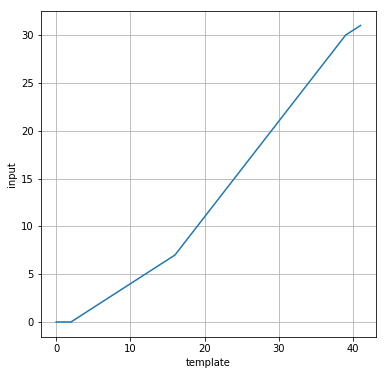

The minimum distance is:
122.34320233319256


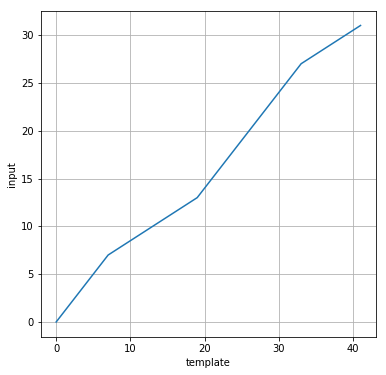

In [16]:
d = genDistMat(mfccs1,mfccs2)
D = genAccumulatedMat1(d)
editdist = getMinDist1(D)
path = getPath1(D)
print("The minimum distance is:")
print(editdist)
plotPath1(path)

d = genDistMat(mfccs1,mfccs3)
D = genAccumulatedMat1(d)
editdist = getMinDist1(D)
path = getPath1(D)
print("The minimum distance is:")
print(editdist)
plotPath1(path)

### 原始标准算法

The minimum distance is:
86.04876760534339


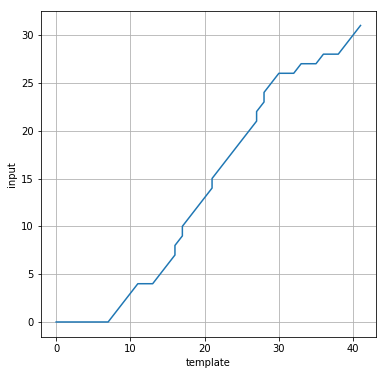

The minimum distance is:
109.26084564827583


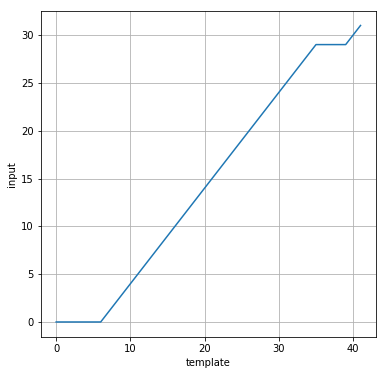

In [18]:
d = genDistMat(mfccs1,mfccs2)
D = genAccumulatedMat2(d)
editdist = getMinDist2(D)
path = getPath2(D)
print("The minimum distance is:")
print(editdist)
plotPath2(path)

d = genDistMat(mfccs1,mfccs3)
D = genAccumulatedMat2(d)
editdist = getMinDist2(D)
path = getPath2(D)
print("The minimum distance is:")
print(editdist)
plotPath2(path)

## 单一模板

In [30]:
yes = 0
summary = []
for inputs in final_test:
    distlist = []
    for i in range(len(train)):
        t = np.random.randint(0,len(train[i]))
        d = genDistMat(inputs[0],train[i][t])
        D = genAccumulatedMat1(d)
        editdist = getMinDist1(D)
        distlist.append(editdist)
    res = distlist.index(min(distlist))
    if inputs[1] == res:
        yes += 1
        summary.append(inputs[1])
        
correctness = 1.0*yes/len(final_test)
print(correctness)
print("The correct ones are:")
print(summary)

0.25
The correct ones are:
[0, 2, 6, 8, 9]


## 多模板之与每一个都进行匹配

### 测试集上的正确率

In [23]:
#  frames been compressed
yes = 0
summary = []
for inputs in final_test:
    distlist = []
    for template in final_train:
        d = genDistMat(inputs[0],template[0])
        D = genAccumulatedMat1(d)
        editdist = getMinDist1(D)
        distlist.append(editdist)
    res = distlist.index(min(distlist))
    if inputs[1] == final_train[res][1]:
        yes += 1
        summary.append(inputs[1])
        
correctness = 1.0*yes/len(final_test)
print(correctness)
print("The correct ones are:")
print(summary)

0.4
The correct ones are:
[0, 1, 1, 2, 2, 6, 9, 9]


In [25]:
# original version
yes = 0
summary = []
for inputs in final_test:
    distlist = []
    for template in final_train:
        d = genDistMat(inputs[0],template[0])
        D = genAccumulatedMat2(d)
        editdist = getMinDist2(D)
        distlist.append(editdist)
    res = distlist.index(min(distlist))
    if inputs[1] == final_train[res][1]:
        yes += 1
        summary.append(inputs[1])
        
correctness = 1.0*yes/len(final_test)
print(correctness)
print("The correct ones are:")
print(summary)

0.65
The correct ones are:
[0, 1, 2, 2, 3, 4, 4, 6, 6, 7, 8, 8, 9]


## 结论

使用不同路径方式得到单一模板baseline模型总体的正确率分别为0.25，多模板的每一个样本都进行匹配模型的总体正确率分别为0.4和0.65，可见多模板效果明显优于单一模板，并且使用压缩帧数的路径搜寻方式没有标准的搜寻方式效果好

## 提高模板

### Template Averaging

taking the average of all available templates

* pick one template as a master

* align all other templates to it
    
* use the alignments generated to compute their average
